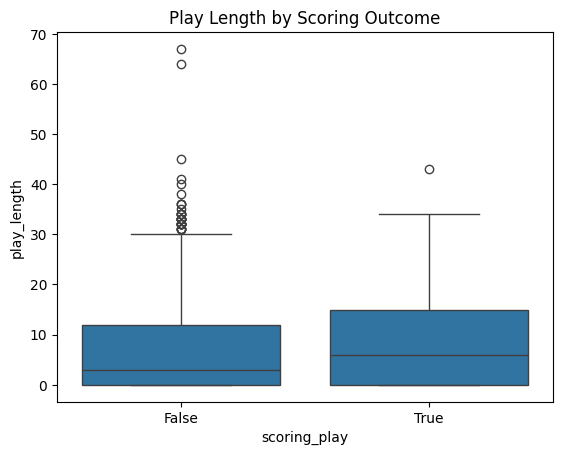

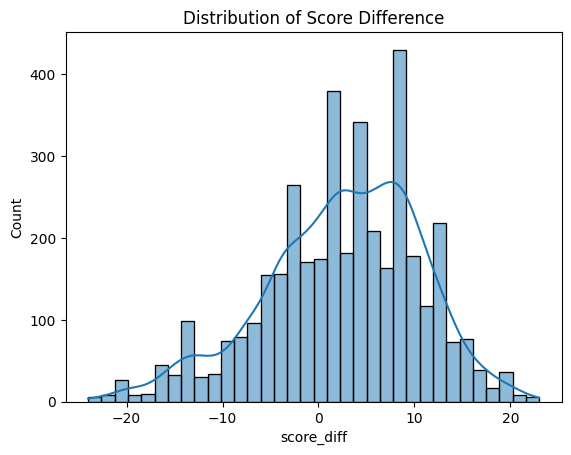

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
file_path = 'Syracuse_Basketball.csv'
data = pd.read_csv(file_path)

# Step 1: Exploratory Data Analysis (EDA)
# Filter data to focus on Syracuse team
syracuse_data = data[(data['home'] == 'Syracuse') | (data['away'] == 'Syracuse')]
syracuse_shots = syracuse_data[syracuse_data['shot_team'] == 'Syracuse'].dropna(subset=['shot_outcome', 'shooter'])


# Check for missing values
missing_values = syracuse_data.isnull().sum()

# Basic descriptive statistics to understand data distribution
desc_stats = syracuse_data.describe()

# Visualize relationships between features
sns.boxplot(data=syracuse_data, x='scoring_play', y='play_length')
plt.title("Play Length by Scoring Outcome")
plt.show()

sns.histplot(syracuse_data['score_diff'], kde=True)
plt.title("Distribution of Score Difference")
plt.show()



In [2]:
# Assuming `syracuse_shots` DataFrame contains the existing data
# Step 1: Define Clutch Time Periods
syracuse_shots['is_5min_clutch'] = syracuse_shots['secs_remaining'] <= 300  # Last 5 minutes
syracuse_shots['is_2min_clutch'] = syracuse_shots['secs_remaining'] <= 120  # Last 2 minutes
syracuse_shots['is_final_shot'] = syracuse_shots['secs_remaining'] <= 24    # Last 24 seconds (buzzer-beater)

# Step 2: Feature Engineering (Create new features first)
# Calculate Shooting Success Rate for each player
shooting_success = syracuse_shots.groupby('shooter')['shot_outcome'].apply(
    lambda x: (x == 'made').sum() / len(x) if len(x) > 0 else 0
).reset_index(name='shooting_success_rate')
syracuse_shots = syracuse_shots.merge(shooting_success, on='shooter', how='left')

# Step 3: Calculate 5-Minute Clutch Success Rate
clutch_5min_success = syracuse_shots[syracuse_shots['is_5min_clutch']].groupby('shooter')['shot_outcome'].apply(
    lambda x: (x == 'made').sum() / len(x) if len(x) > 0 else 0
).reset_index(name='5min_clutch_success_rate')

# Step 4: Calculate 2-Minute Clutch Success Rate
clutch_2min_success = syracuse_shots[syracuse_shots['is_2min_clutch']].groupby('shooter')['shot_outcome'].apply(
    lambda x: (x == 'made').sum() / len(x) if len(x) > 0 else 0
).reset_index(name='2min_clutch_success_rate')

# Step 5: Calculate Final Shot Success Rate (last 24 seconds)
final_shot_success = syracuse_shots[syracuse_shots['is_final_shot']].groupby('shooter')['shot_outcome'].apply(
    lambda x: (x == 'made').sum() / len(x) if len(x) > 0 else 0
).reset_index(name='final_shot_success_rate')

# Step 6: Merge these clutch success features back to the main DataFrame
syracuse_shots = syracuse_shots.merge(clutch_5min_success, on='shooter', how='left')
syracuse_shots = syracuse_shots.merge(clutch_2min_success, on='shooter', how='left')
syracuse_shots = syracuse_shots.merge(final_shot_success, on='shooter', how='left')

# Fill any NaN values with 0 (in case any players have no shots in these timeframes)
syracuse_shots[['5min_clutch_success_rate', '2min_clutch_success_rate', 'final_shot_success_rate']] = syracuse_shots[
    ['5min_clutch_success_rate', '2min_clutch_success_rate', 'final_shot_success_rate']
].fillna(0)

# Calculate Fouls Drawn per player
if 'foul' in syracuse_shots.columns and syracuse_shots['foul'].any():
    fouls_drawn = syracuse_shots[syracuse_shots['foul']].groupby('shooter').size().reset_index(name='fouls_drawn')
else:
    fouls_drawn = pd.DataFrame({'shooter': syracuse_shots['shooter'].unique(), 'fouls_drawn': 0})
syracuse_shots = syracuse_shots.merge(fouls_drawn, on='shooter', how='left')
syracuse_shots['fouls_drawn'].fillna(0, inplace=True)

# Calculate Three-Point Ratio
three_point_ratio = syracuse_shots.groupby('shooter')['three_pt'].apply(
    lambda x: (x == 'True').sum() / len(x) if len(x) > 0 else 0
).reset_index(name='three_point_ratio')
syracuse_shots = syracuse_shots.merge(three_point_ratio, on='shooter', how='left')

# Calculate Recent Performance (rolling average of last 5 scoring plays)
recent_performance = syracuse_shots.groupby('shooter')['scoring_play'].rolling(5).mean().reset_index(level=0, drop=True).fillna(0)
syracuse_shots['recent_performance'] = recent_performance.values

# Calculate Win Probability Gap
syracuse_shots['win_prob_gap'] = abs(syracuse_shots['win_prob'] - syracuse_shots['naive_win_prob'])

# High-Pressure Indicator: Identify if the win probability is below 50% (indicating the game is uncertain)
syracuse_shots['high_pressure'] = (syracuse_shots['win_prob'] < 0.5).astype(int)

# Possession Change
syracuse_shots['possession_change'] = (syracuse_shots['possession_before'] != syracuse_shots['possession_after']).astype(int)

# Possession Length
syracuse_shots['possession_length'] = syracuse_shots.groupby('possession_before')['play_length'].cumsum()

# Scoring Streak: Cumulative count of consecutive successful scoring plays
scoring_streak = syracuse_shots.groupby('shooter')['scoring_play'].apply(lambda x: (x == 1).cumsum()).reset_index(level=0, drop=True)
syracuse_shots['scoring_streak'] = scoring_streak

# Home Team Advantage: Whether the home team is leading
syracuse_shots['home_team_advantage'] = (syracuse_shots['home_score'] > syracuse_shots['away_score']).astype(int)

# Timeout Pressure: Calculate if both teams have only one or zero timeouts left
syracuse_shots['timeout_pressure'] = ((syracuse_shots['home_time_out_remaining'] <= 1) &
                                      (syracuse_shots['away_time_out_remaining'] <= 1)).astype(int)

# Add time remaining feature for modeling
syracuse_shots['time_remaining'] = syracuse_shots['secs_remaining']

# Create target variable for scoring success
syracuse_shots['successful_shot'] = syracuse_shots['shot_outcome'].apply(lambda x: 1 if x == 'made' else 0)

# Print the new DataFrame to verify the additional features
print(syracuse_shots[['win_prob', 'naive_win_prob', 'win_prob_gap', 'high_pressure', 
                      'possession_change', 'possession_length', 'scoring_streak', 
                      'home_team_advantage', 'timeout_pressure']].head())


   win_prob  naive_win_prob  win_prob_gap  high_pressure  possession_change  \
0  0.710820        0.545635      0.165185              0                  1   
1  0.710902        0.546611      0.164291              0                  1   
2  0.710948        0.547378      0.163571              0                  1   
3  0.710967        0.547810      0.163157              0                  0   
4  0.710972        0.547970      0.163003              0                  1   

   possession_length  scoring_streak  home_team_advantage  timeout_pressure  
0                 27               0                    1                 0  
1                 52               0                    1                 0  
2                 59               0                    1                 0  
3                 62               0                    1                 0  
4                 62               0                    1                 0  


/tmp/ipykernel_15611/4120786903.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  syracuse_shots['fouls_drawn'].fillna(0, inplace=True)


In [3]:
# Step 3: Preprocessing
from sklearn.preprocessing import StandardScaler

# Handle missing values by filling them with appropriate values
syracuse_shots['shooting_success_rate'].fillna(0, inplace=True)
syracuse_shots['5min_clutch_success_rate'].fillna(0, inplace=True)
syracuse_shots['2min_clutch_success_rate'].fillna(0, inplace=True)
syracuse_shots['final_shot_success_rate'].fillna(0, inplace=True)
syracuse_shots['fouls_drawn'].fillna(0, inplace=True)
syracuse_shots['three_point_ratio'].fillna(0, inplace=True)
syracuse_shots['recent_performance'].fillna(0, inplace=True)
syracuse_shots['win_prob_gap'].fillna(0, inplace=True)
syracuse_shots['possession_length'].fillna(0, inplace=True)
syracuse_shots['scoring_streak'].fillna(0, inplace=True)
syracuse_shots['time_remaining'].fillna(0, inplace=True)  # Handle missing values for time_remaining

# Scaling numerical features for consistency
scaler = StandardScaler()
numerical_features = [
    'shooting_success_rate', '5min_clutch_success_rate', '2min_clutch_success_rate', 
    'final_shot_success_rate', 'fouls_drawn', 'three_point_ratio', 'recent_performance', 
    'win_prob_gap', 'possession_length', 'scoring_streak', 'time_remaining'
]
syracuse_shots[numerical_features] = scaler.fit_transform(syracuse_shots[numerical_features])

# Confirm that the features have been processed and scaled correctly
print(syracuse_shots[numerical_features].head())



   shooting_success_rate  5min_clutch_success_rate  2min_clutch_success_rate  \
0               0.545845                  0.102015                 -0.242224   
1               0.545845                  0.102015                 -0.242224   
2              -0.885382                 -1.078802                  0.175610   
3               0.545845                  0.102015                 -0.242224   
4               1.676117                  1.437409                  0.761662   

   final_shot_success_rate  fouls_drawn  three_point_ratio  \
0                 0.599058          0.0                0.0   
1                 0.599058          0.0                0.0   
2                -1.372971          0.0                0.0   
3                 0.599058          0.0                0.0   
4                 0.106051          0.0                0.0   

   recent_performance  win_prob_gap  possession_length  scoring_streak  \
0           -1.888396      0.591641          -1.739968       -1.107048  

/tmp/ipykernel_15611/603040191.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  syracuse_shots['shooting_success_rate'].fillna(0, inplace=True)
/tmp/ipykernel_15611/603040191.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

In [5]:
syracuse_data.head()
syracuse_shots.to_csv('syracuse_shots.csv')


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model saved as 'random_forest_model.pkl'
Model Accuracy: 0.5916230366492147
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.62      0.59        91
           1       0.62      0.57      0.59       100

    accuracy                           0.59       191
   macro avg       0.59      0.59      0.59       191
weighted avg       0.59      0.59      0.59       191

Feature Importances:
                          importance
time_remaining              0.192867
win_prob_gap                0.186900
possession_length           0.173920
scoring_streak              0.151665
recent_performance          0.084553
shooting_success_rate       0.052548
possession_change           0.042421
5min_clutch_success_rate    0.028921
2min_clutch_success_rate    0.025093
home_team_advantage         0.021699
final_shot_success_rate     0.019855
high_pressure               0.019555


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]

SHAP Summary Plot for Feature Importance


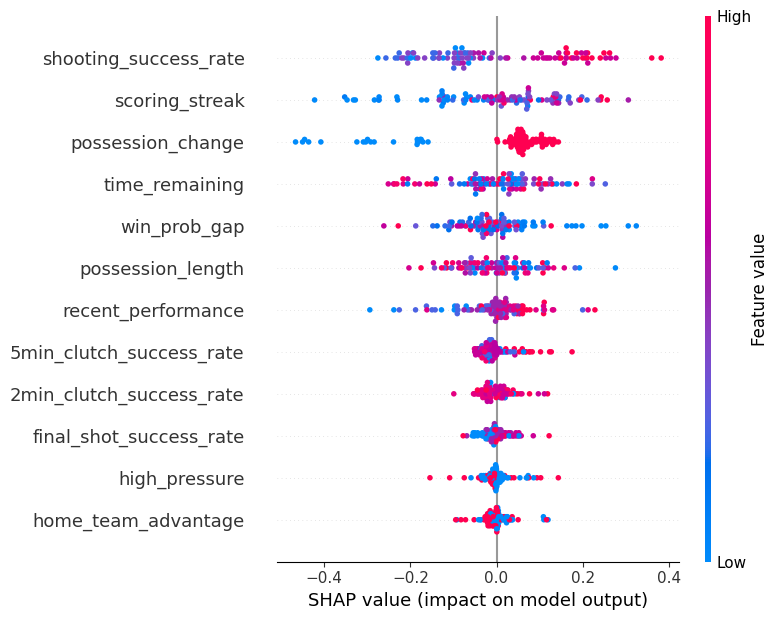

The recommended player for the winning shot is: Judah Mintz
SHAP Force Plot for Player: Judah Mintz


In [ ]:
!pip install shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import shap
import pandas as pd
import pickle 

# Step 1: Define features and target (as given), including clutch success rate features
X = syracuse_shots[['shooting_success_rate', 'recent_performance', 'win_prob_gap', 'possession_length', 
                    'scoring_streak', 'time_remaining', 'home_team_advantage', 'high_pressure', 
                    'possession_change', '5min_clutch_success_rate', '2min_clutch_success_rate', 
                    'final_shot_success_rate']]
y = syracuse_shots['successful_shot']

# Step 2: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Save the trained model to a pickle file
with open("winning_shot_model.pkl", "wb") as file:
    pickle.dump(model, file)
print("Model saved as 'random_forest_model.pkl'")

# Step 4: Prediction and Evaluation
# Predict on test data
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Step 5: Determine feature importance to understand factors influencing shot success
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

# Step 6: Explain Model Decision for Winning Shot Player with SHAP
# Using shap.KernelExplainer for more robust interpretability in binary classification
# Selecting a sample to avoid KernelExplainer performance issues
sample_X_test = X_test.sample(100, random_state=42)  # Use a subset to speed up SHAP calculation

explainer = shap.KernelExplainer(model.predict, sample_X_test)
shap_values = explainer.shap_values(sample_X_test)

# Global feature importance with SHAP summary plot
print("SHAP Summary Plot for Feature Importance")
shap.initjs()
shap.summary_plot(shap_values, sample_X_test, feature_names=X.columns)  # SHAP summary for sampled dataset

# Identify the first player in X_test predicted as a winning shot (successful_shot = 1)
predicted_success_indices = X_test.index[y_pred == 1]  # Indices of players predicted for successful shots
if len(predicted_success_indices) > 0:
    best_shooter_index = predicted_success_indices[0]  # Select the first player predicted to succeed
    best_shooter = syracuse_shots.loc[best_shooter_index, 'shooter']
    print(f"The recommended player for the winning shot is: {best_shooter}")

    # Use SHAP force plot for the chosen player to see individual feature contributions
    print(f"SHAP Force Plot for Player: {best_shooter}")
    shap.force_plot(
        explainer.expected_value, 
        shap_values[X_test.index.get_loc(best_shooter_index)], 
        X_test.loc[best_shooter_index], 
        feature_names=X.columns.tolist()
    )
else:
    print("No player was predicted as the best choice for the winning shot.")
